In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
!pip install pandas
!pip install scikit-learn
!pip install skforecast
!pip install matplotlib




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Descarga de datos
# ==============================================================================
arch = ('drive/MyDrive/MATRICES/completo_ok.csv')
datos = pd.read_csv(arch)

datos.info()
datos.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7295 entries, 0 to 7294
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   int64  
 1   Fecha        7295 non-null   object 
 2   Dia          7295 non-null   int64  
 3   Demanda      7295 non-null   int64  
 4   Temperatura  7295 non-null   float64
 5   Feriado      7295 non-null   int64  
 6   Publico      7295 non-null   int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 399.1+ KB


,ID,Fecha,Dia,Demanda,Temperatura,Feriado,Publico
0,0,2021/07/01 00:00,4,1721748533,8.7,0,0
1,1,2021/07/01 01:00,4,1731462994,8.4,0,0
2,2,2021/07/01 02:00,4,1676358588,8.2,0,0
3,3,2021/07/01 03:00,4,1653972981,7.7,0,0
4,4,2021/07/01 04:00,4,1653886127,7.2,0,0


In [5]:
# Conversión del formato fecha
# ==============================================================================
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos = datos.set_index('Fecha')
datos = datos.asfreq('60min')
datos = datos.sort_index()
datos.info()
datos.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7297 entries, 2021-07-01 00:00:00 to 2022-05-01 00:00:00
Freq: 60T
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           7295 non-null   float64
 1   Dia          7295 non-null   float64
 2   Demanda      7295 non-null   float64
 3   Temperatura  7295 non-null   float64
 4   Feriado      7295 non-null   float64
 5   Publico      7295 non-null   float64
dtypes: float64(6)
memory usage: 399.1 KB


,ID,Dia,Demanda,Temperatura,Feriado,Publico
Fecha,,,,,,
2021-07-01 00:00:00,0.0,4.0,1.721749e+09,8.7,0.0,0.0
2021-07-01 01:00:00,1.0,4.0,1.731463e+09,8.4,0.0,0.0
2021-07-01 02:00:00,2.0,4.0,1.676359e+09,8.2,0.0,0.0
2021-07-01 03:00:00,3.0,4.0,1.653973e+09,7.7,0.0,0.0
2021-07-01 04:00:00,4.0,4.0,1.653886e+09,7.2,0.0,0.0


In [6]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

True

In [7]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2021-07-01 00:00:00': '2022-05-01 23:00:00']
fin_train = '2022-01-31 23:59:00'
fin_validacion = '2022-03-31 00:00:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2021-07-01 00:00:00 --- 2022-01-31 23:00:00  (n=5160)
Fechas validacion : 2022-02-01 00:00:00 --- 2022-03-31 00:00:00  (n=1393)
Fechas test       : 2022-03-31 00:00:00 --- 2022-05-01 00:00:00  (n=745)


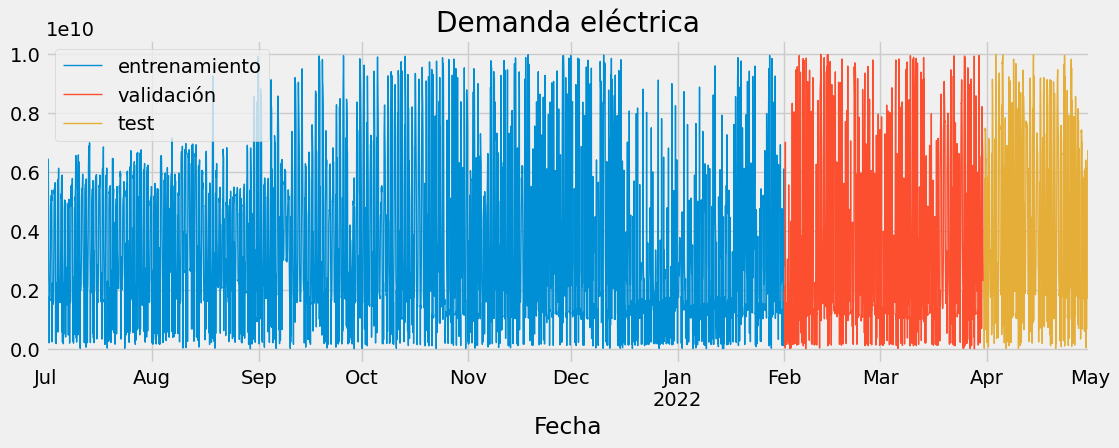

In [8]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demanda.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demanda.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demanda.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

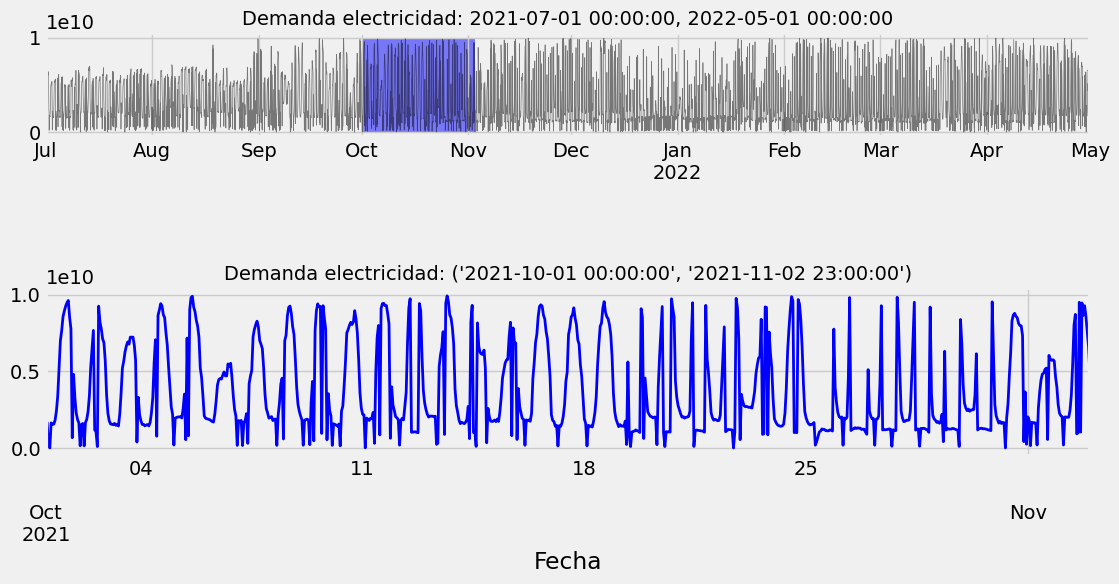

In [9]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2021-10-01 00:00:00','2021-11-02 23:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demanda.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demanda)
max_y = max(datos.Demanda)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demanda.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

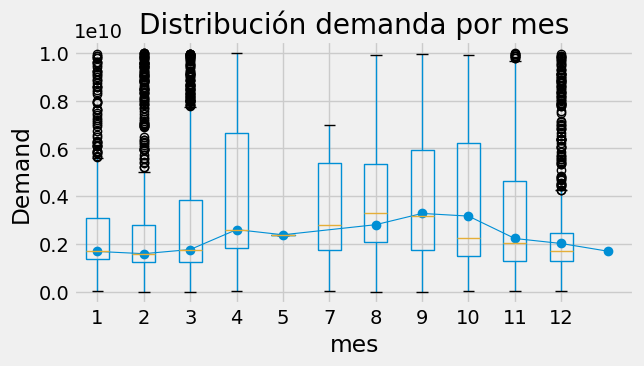

In [10]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demanda', by='mes', ax=ax,)
datos.groupby('mes')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

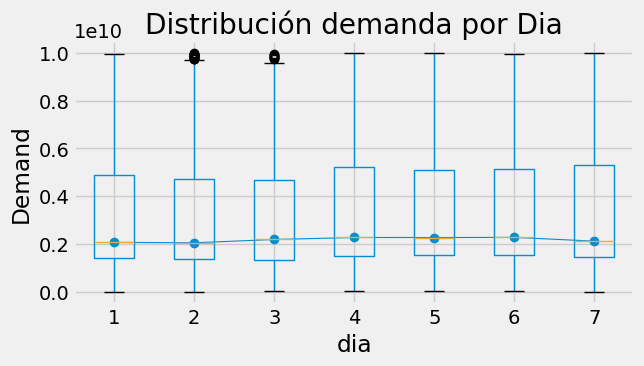

In [11]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['dia'] = datos.index.day_of_week+1
datos.boxplot(column='Demanda', by='dia', ax=ax,)
datos.groupby('dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por Dia')
fig.suptitle('');

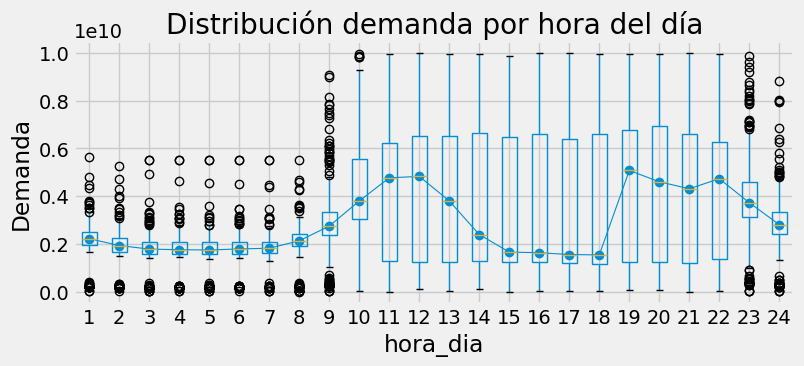

In [12]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demanda', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demanda'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

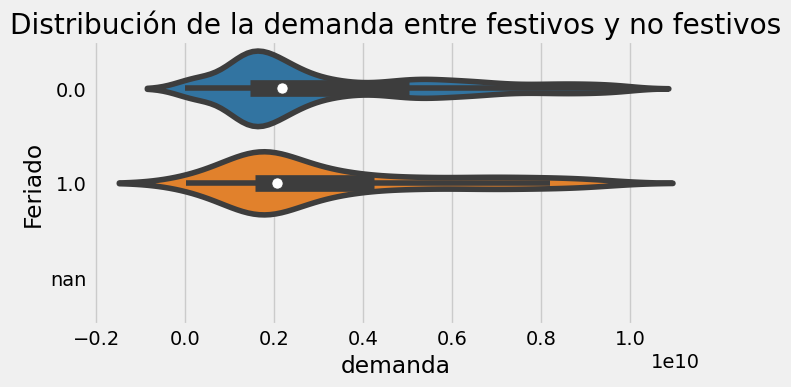

In [13]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demanda',
    y       = 'Feriado',
    data    = datos.assign(Feriado = datos.Feriado.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('Feriado');

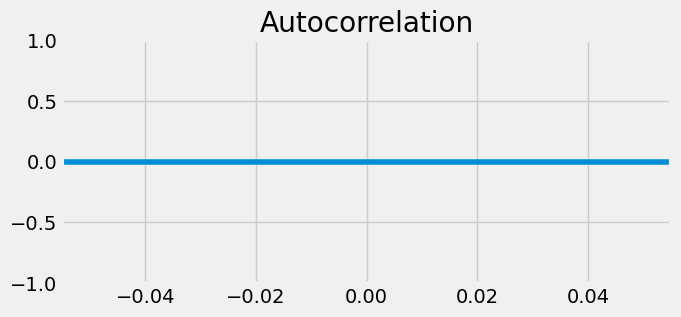

In [14]:
# Gráfico de autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos.Demanda, ax=ax, lags=60)
plt.show()

In [15]:
#### Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(y=datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-01 00:00:00'), Timestamp('2021-11-02 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-21 20:20:27 
Last fit date: 2023-04-21 20:20:27 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2021-10-01 00:00:00'), Timestamp('2021-11-02 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: 60T 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-21 20:20:34 
Last fit date: 2023-04-21 20:20:34 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [17]:
# Crear forecaster
# ==============================================================================
from lightgbm import LGBMRegressor
forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags = 7
            )
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [1 2 3 4 5 6 7] 
Transformer for y: None 
Transformer for exog: None 
Window size: 7 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-04-21 20:20:49 
Last fit date: None 
Skforecast version: 0.7.0 
Python version: 3.9.16 
Forecaster id: None 

In [18]:
# Grid search de hyper-parámetros y lags
# ==============================================================================
# Hyper-parámetros del regresor
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags utilizados como predictores
lags_grid = [7]

results_grid_q10 = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = 7,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = 45,
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False
                   )

Number of models compared: 12.


loop lags_grid: 100%|██████████████████████████████████████| 1/1 [02:18<00:00, 138.94s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 6.449474025648205e+18



In [19]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'],
                            initial_train_size = 47,
                            fixed_train_size   = False,
                            steps      = 7,
                            refit      = True,
                            interval   = [10, 90],
                            n_boot     = 1000,
                            metric     = 'mean_squared_error',
                            verbose    = False
                      )
predictions.head(4)

,pred,lower_bound,upper_bound
2021-10-02 23:00:00,4.685564e+09,1.081363e+09,8.942916e+09
2021-10-03 00:00:00,4.685564e+09,1.081363e+09,9.252964e+09
2021-10-03 01:00:00,4.685564e+09,6.789309e+08,9.252964e+09
2021-10-03 02:00:00,4.685564e+09,1.041119e+09,8.942916e+09


In [20]:
# Cobertura del intervalo en los datos de test
# ==============================================================================
inside_interval = np.where(
                     (datos.loc[predictions.index, 'Demanda'] >= predictions['lower_bound']) & \
                     (datos.loc[predictions.index, 'Demanda'] <= predictions['upper_bound']),
                     True,
                     False
                  )

coverage = inside_interval.mean()
print(f"Cobertura del intervalo predicho con los datos de test: {100 * coverage}")

Cobertura del intervalo predicho con los datos de test: 56.241610738255034


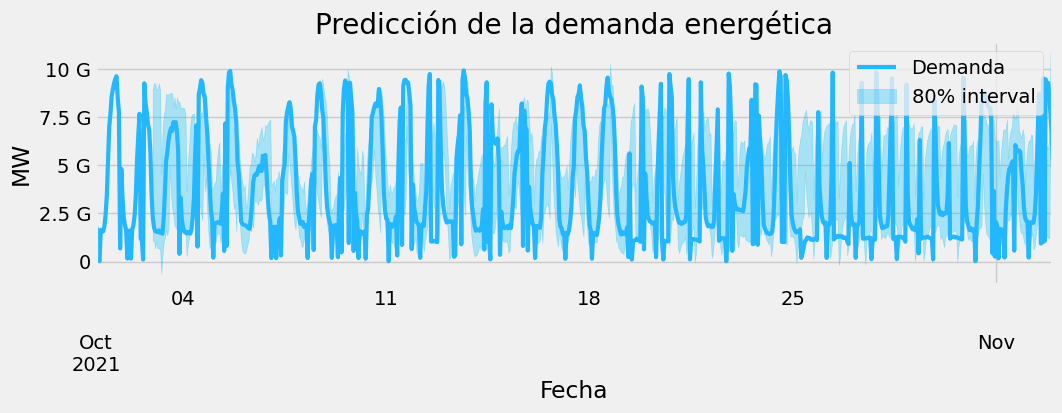

In [21]:
# Gráfico
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig, ax=plt.subplots(figsize=(11, 3))
datos.Demanda['2021-10-01 00:00':'2021-11-02 23:00'].plot(ax=ax, label='Demanda', linewidth=3, color="#23b7ff")
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'deepskyblue',
    alpha = 0.3,
    label = '80% interval'
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_title('Predicción de la demanda energética')
ax.legend();

In [37]:
error_mse = mean_squared_error(
                y_true = datos.Demanda['2021-10-01 00:00':'2021-11-01 00:00'],
                y_pred = predictions.iloc[:, 0]                
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 7.91099277887778e+18


In [38]:
print(datos.Demanda['2021-10-01 00:00':'2021-11-01 00:00'].shape)

(745,)


In [39]:
print(predictions.shape)

(745, 3)
